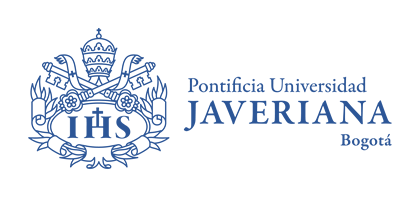

# Aprendizaje de máquina - Laboratorio Naive Bayes
El modelo naive bayes de clasificación permite formular clasificadores maximizando la verosimilitud del modelo sobre los parámetros. Dependiendo del modelo e información disponible, cada modelo utiliza sus parámetros de forma diferente. Lo interesante de estos tipos de modelos vistos en clase es que al maximizar la probabilidad de los mismos, los parámetros resultan siendo elementos simples y fáciles de calcular para los modelos gaussianos y naive bayes.

Los objetivos de este notebook son los siguientes:

*   Revisar el comportamiento de los modelos gaussianos y multinomal bernoulli usando sklearn en python
*   Comparar modelo multinomial con regresión logística


**Créditos**

Este notebook esta adaptado a partir del contenido del libro  Python Data Science Handbook de Jake VanderPlas disponible en Github [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

* El libro esta liberado bajo licencia creative commons [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode)

# Import de librerias

In [310]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


## Modelo gaussiano

El modelo generativo gaussiano asume que la probabilidad que una instancia pertenezca a una clase $y$ esta dado por una probabilidad de una distribución gausiana con promedio $\mu\in \mathbb{R}^m$ y covarianza $\Sigma^2$

$P(x|y)=\frac{1}{2\pi^{n/2} |\Sigma|^{1/2}}exp(-\frac{1}{2}(x-\mu_{y})^{T}\Sigma^{-1}(x-\mu_{y}))$

Consideremos los siguientes puntos sintéticos, usando 2 clases que están agrupadas frente a su promedio

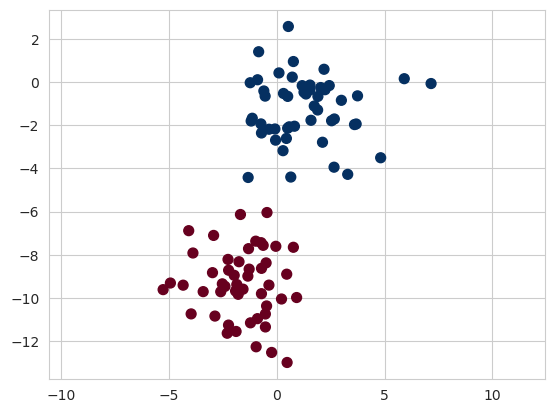

In [311]:
sns.set_style("whitegrid")
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');
plt.axis('equal');

Usando el modelo naive bayes, vamos a entrenar un modelo gaussiano para encontrar los parámetros $\mu$ por clase y $\Sigma$

In [312]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

In [313]:
# Probabilidad por clase, son equiprobables por que los conteos son iguales
model.class_prior_

array([0.5, 0.5])

In [314]:
# Promedios por clase, clase 0 es la roja y clase 1 la azul
model.theta_

array([[-1.64939095, -9.36891451],
       [ 1.29327924, -1.24101221]])

In [315]:
# Varianza de los datos (varianza por clase y por feature)
model.var_

array([[2.06097005, 2.47716872],
       [3.33164807, 2.22401384]])

Ilustremos la distribución de probabilidad aprendida sobre una grilla

In [316]:
padding = 1.0
x_min, x_max = X[:,0].min() - padding, X[:,0].max() + padding
y_min, y_max = X[:,1].min() - padding, X[:,1].max() + padding
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]

In [317]:



# Definición función de probabilidad para X
def gaussian_likelihood(X, mean, var):
    d = X.shape[1]
    norm_const = (2*np.pi)**(-d/2) * np.prod(var**-0.5)
    diff = X - mean
    expo = -0.5 * np.sum((diff**2) / var, axis=1)
    return norm_const * np.exp(expo)

In [318]:

eps = 1e-6
# Corremos el modelo para obtener la distribución de la grilla por cada clase
likelihoods = []
for k, cls in enumerate(model.classes_):
    mu_k = model.theta_[k]
    var_k = model.var_[k]
    lk = gaussian_likelihood(grid, mu_k, var_k).reshape(xx.shape)
    likelihoods.append(lk)

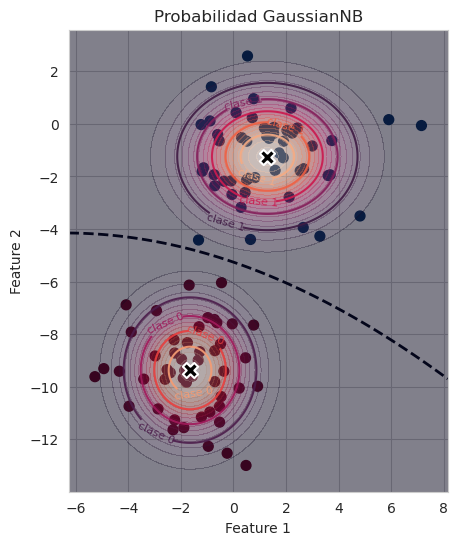

In [319]:

fig, ax = plt.subplots(figsize=(7,6))

# Diagrama dispersion original
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_aspect('equal', adjustable='box')

levels = 6  # niveles de countour
for k, lk in enumerate(likelihoods):
    cs = ax.contour(xx, yy, lk, levels=levels, alpha=0.9)
    cf = ax.contourf(xx, yy, lk, levels=20, alpha=0.3)
    ax.clabel(cs, inline=True, fontsize=8, fmt={lev: f"clase {model.classes_[k]}" for lev in cs.levels})

# Probabilidad posterior de la última clase (model.classes_[-1])
proba = model.predict_proba(grid)[:, -1].reshape(xx.shape)

# Curva de nivel 0.5 (frontera de decisión)
cs_boundary = ax.contour(xx, yy, proba, levels=[0.5],
                         linewidths=2.0, linestyles='--')


ax.scatter(
    model.theta_[:, 0],
    model.theta_[:, 1],
    c="black",
    s=120,
    marker="X",
    edgecolor="white",
    linewidth=1.5,
    label="Promedios"
)

ax.set_title("Probabilidad GaussianNB")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()

In [320]:
logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

In [321]:
proba_lr = logreg.predict_proba(grid)[:, 1].reshape(xx.shape)

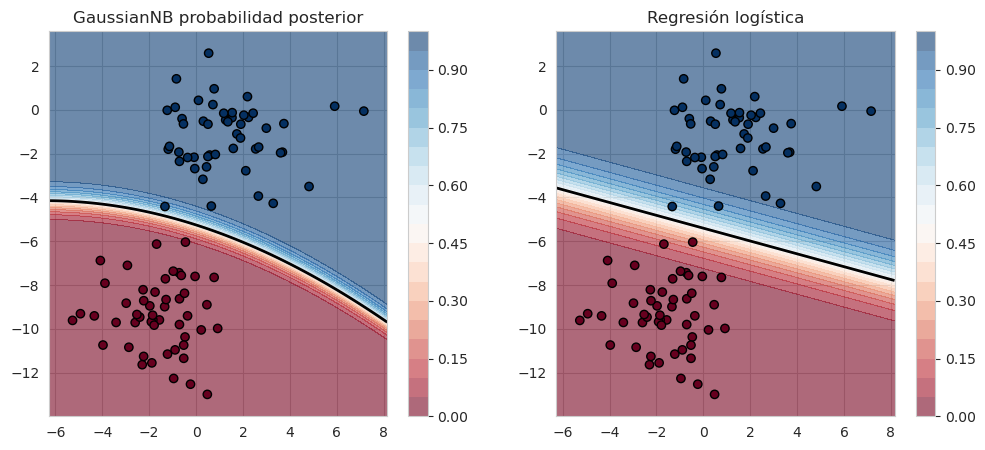

In [322]:

proba_nb = model.predict_proba(grid)[:, 1].reshape(xx.shape)
proba_lr = logreg.predict_proba(grid)[:, 1].reshape(xx.shape)


fig, axs = plt.subplots(1, 2, figsize=(12,5))

# GaussianNB
cf1 = axs[0].contourf(xx, yy, proba_nb, levels=20, cmap='RdBu', alpha=0.6)
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolor="k")
axs[0].contour(xx, yy, proba_nb, levels=[0.5], colors="black", linewidths=2)
axs[0].set_title("GaussianNB probabilidad posterior")
fig.colorbar(cf1, ax=axs[0])

# Logistic Regression
cf2 = axs[1].contourf(xx, yy, proba_lr, levels=20, cmap='RdBu', alpha=0.6)
axs[1].scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolor="k")
axs[1].contour(xx, yy, proba_lr, levels=[0.5], colors="black", linewidths=2)
axs[1].set_title("Regresión logística")
fig.colorbar(cf2, ax=axs[1])

plt.show()

# Naive bayes multinomial

El Naive Bayes multinomialasume que las características se generan a partir de una distribución multinomial simple.

La distribución multinomial describe la probabilidad de observar conteos entre un número de categorías y, por lo tanto, el Naive Bayes multinomial es más apropiado para características que representan conteos o tasas de conteo.

La idea es exactamente la misma que antes, excepto que en lugar de modelar la distribución de los datos con la gaussiana de mejor ajuste, la modelamos con una distribución multinomial de mejor ajuste.

## Clasificación de texto

Un lugar donde se usa con frecuencia el Naive Bayes multinomial es en la clasificación de textos, donde las características están relacionadas con los conteos de palabras o las frecuencias dentro de los documentos a clasificar.


Vamos a descargar los datos y observar los nombres de las clases objetivo:

In [323]:
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Por facilidad vamos a limitar el análisis a 4 categorías



In [324]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [325]:
# Ejemplo, primeros 48 caracteres de la instancia 6
print(train.data[5][48:])

Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Para convertir el texto en una matriz documento término usaremos [TFidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) para convertir los textos a una matriz con entradas TF-IDF. Recuerde que en el modelo Bernoulli se revisa solamente presencia, en cambio en el modelo Multinomial se tiene en cuenta los conteos o en este caso proporciones indicadas por los valores TF-IDF. En vez de conteos de documentos en los que aparece cada palabra sobre el total de documentos como lo hace el modelo Bernoulli, el modelo multinomial suma las apariciones de la palabra en el documento y divide por el total de veces que aparece la palabra en todos los documentos de la clase.

In [326]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Fit-predict

In [327]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [328]:
# Logs de probabilidad de cada clase
log_priors=model[1].class_log_prior_
log_priors

array([-1.30471651, -1.2894231 , -1.2793559 , -1.74237231])

In [329]:
probs = np.exp(log_priors) / np.exp(log_priors).sum()
print("Priors as probabilities:", probs)

Priors as probabilities: [0.27124942 0.27542963 0.27821644 0.17510451]


In [330]:
# Se crea un conteo por cada clase, para 35329 palabras
model[1].feature_count_.shape

(4, 35329)

El modelo utilizando solamente las sumas de

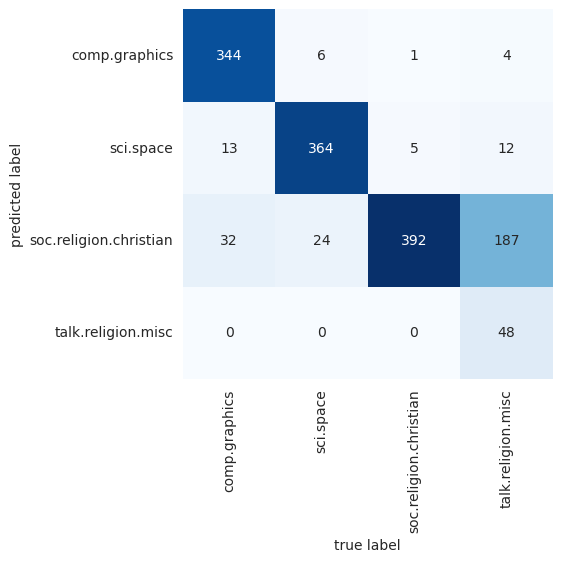

In [331]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names,
            cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [332]:
# Existen métricas de clasificación a nivel micro, macro

# Micro Calcula TP, TF, FP, FN sumando aciertos y desaciertos por clase
precision = precision_score(test.target, labels,average='micro')
recall = recall_score(test.target, labels,average='micro')
f1 = f1_score(test.target, labels,average='micro')

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")

Precision: 0.802
Recall:    0.802
F1 score:  0.802


In [333]:
# Macro Calcula TP, TF, FP, FN por clase y reporta promedios
precision = precision_score(test.target, labels,average='macro')
recall = recall_score(test.target, labels,average='macro')
f1 = f1_score(test.target, labels,average='macro')

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")

Precision: 0.878
Recall:    0.746
F1 score:  0.732


# Ejercicio

Cree un modelo de clasificación logística sobre el ejercicio de los newsgroups, compare resultados y realice conclusiones sobre el ejercicio

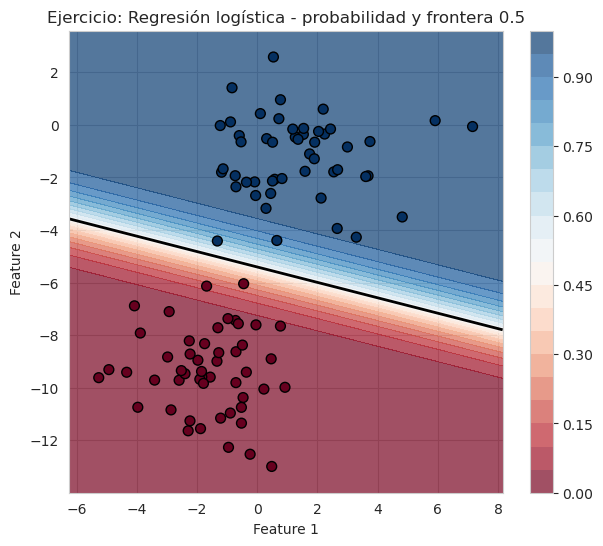

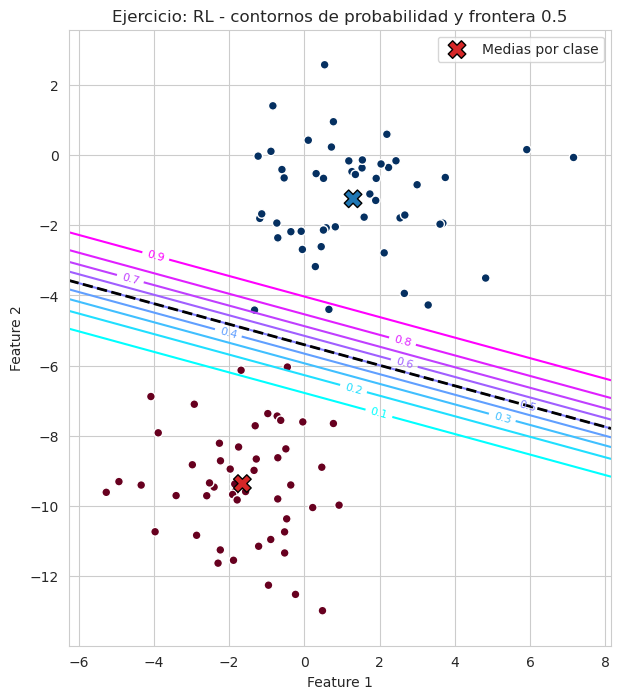

### Conclusiones y comparación
- Compare las métricas impresas (Micro/Macro) de esta regresión logística multinomial desde cero con las del `MultinomialNB` anteriores (micro≈0.802, macro F1≈0.732 en el notebook original).
- En texto, la regresión logística (discriminativa) suele mejorar F1 macro si está bien regularizada y entrenada, mientras que Naive Bayes (generativo) suele ser más simple y rápido, y competitivo en micro.
- Diferencias dependen de:
  - Representación: aquí se usa TF‑IDF normalizado L2; ajustar `max_features`, `min_df` o tokenización puede cambiar resultados.
  - Entrenamiento: `epochs`, `lr`, `reg` y tamaño de batch. Pequeños ajustes suelen mejorar macro‑F1.
- Recomendación práctica: usar LR como baseline fuerte para texto; NB como baseline muy rápido y robusto. 


## Clasificación logística multinomial desde cero (sin librerías de ML)
En esta sección implementamos paso a paso:
- Carga de datos (mismas 4 categorías de 20 Newsgroups)
- Tokenización y construcción de vocabulario
- Vectorización TF‑IDF esparsa manual
- Modelo softmax (regresión logística multinomial)
- Entrenamiento con descenso de gradiente por mini‑lotes
- Evaluación (matriz de confusión, micro/macro) y comparación con `MultinomialNB`


### 1) Imports y configuración
En esta sección importamos sólo librerías base (re y NumPy). Usamos `sklearn.datasets.fetch_20newsgroups` únicamente para descargar el dataset, no para modelado.


In [336]:
import re
import math
import numpy as np
from collections import Counter
from sklearn.datasets import fetch_20newsgroups

np.random.seed(0)


### 2) Carga de datos y categorías
Usamos el mismo subconjunto de 4 categorías para ser comparables con `MultinomialNB`.


In [337]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)
K = len(train.target_names)
print('Clases:', train.target_names)


Clases: ['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']


### 3) Tokenización
Definimos una tokenización simple basada en regex (palabras de ≥2 letras). Todo se pasa a minúsculas.


In [338]:
TOKEN_RE = re.compile(r"[A-Za-z]{2,}")

def tokenize(text):
    return [t.lower() for t in TOKEN_RE.findall(text)]


### 4) Vocabulario y frecuencias de documento (DF)
Construimos un vocabulario limitado por frecuencia mínima y máximo de términos.


In [339]:
max_features = 20000
min_df = 3

df_counter = Counter()
for doc in train.data:
    toks = set(tokenize(doc))
    df_counter.update(toks)

vocab_terms = [w for w, c in df_counter.most_common(max_features) if c >= min_df]
vocab = {w: i for i, w in enumerate(vocab_terms)}
V = len(vocab)
print('Tamaño vocabulario:', V)


Tamaño vocabulario: 12237


### 5) Construcción de TF‑IDF esparso (CSR manual)
Creamos una representación esparsa estilo CSR a partir de TF‑IDF con normalización L2 por documento.


In [340]:
def build_tfidf_csr(texts, vocab, df_counter):
    N = len(texts)
    indptr = [0]
    indices = []
    data = []
    for doc in texts:
        toks = tokenize(doc)
        tf = Counter(t for t in toks if t in vocab)
        if not tf:
            indptr.append(len(indices))
            continue
        row_indices = []
        row_data = []
        for term, cnt in tf.items():
            j = vocab[term]
            df = df_counter[term]
            idf = math.log((N + 1) / (df + 1)) + 1.0
            val = (cnt / len(toks)) * idf
            row_indices.append(j)
            row_data.append(val)
        norm = math.sqrt(sum(v*v for v in row_data)) or 1.0
        row_data = [v / norm for v in row_data]
        order = np.argsort(row_indices)
        for o in order:
            indices.append(row_indices[o])
            data.append(row_data[o])
        indptr.append(len(indices))
    return (np.array(indptr, dtype=np.int64),
            np.array(indices, dtype=np.int32),
            np.array(data, dtype=np.float32))

indptr_tr, indices_tr, data_tr = build_tfidf_csr(train.data, vocab, df_counter)
indptr_te, indices_te, data_te = build_tfidf_csr(test.data, vocab, df_counter)
print('Filas train/test:', len(indptr_tr)-1, len(indptr_te)-1)


Filas train/test: 2153 1432


### 6) Modelo: regresión logística multinomial (softmax)
Definimos parámetros `W` (V×K) y `b` (K), y utilidades `softmax` y pérdida NLL con gradiente (mini‑batch).


In [341]:
V = len(vocab)
W = 0.01 * np.random.randn(V, K).astype(np.float32)
b = np.zeros((K,), dtype=np.float32)

def softmax(z):
    z = z - z.max(axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / expz.sum(axis=1, keepdims=True)

def nll_and_grad(indptr, indices, data, y, W, b, reg=1e-4, batch_size=256):
    N = len(indptr) - 1
    perm = np.random.permutation(N)
    total_loss = 0.0
    gW = np.zeros_like(W)
    gb = np.zeros_like(b)
    for s in range(0, N, batch_size):
        idx = perm[s:s+batch_size]
        Z = np.zeros((len(idx), K), dtype=np.float32)
        for t, i in enumerate(idx):
            start, end = indptr[i], indptr[i+1]
            cols = indices[start:end]
            vals = data[start:end]
            Z[t] = (vals[:, None] * W[cols]).sum(axis=0) + b
        P = softmax(Z)
        yb = y[idx]
        loss = -np.log(P[np.arange(len(idx)), yb] + 1e-12).mean()
        G = P
        G[np.arange(len(idx)), yb] -= 1.0
        G /= len(idx)
        for t, i in enumerate(idx):
            start, end = indptr[i], indptr[i+1]
            cols = indices[start:end]
            vals = data[start:end]
            gW[cols] += (vals[:, None] * G[t])
        gb += G.sum(axis=0)
        total_loss += loss
    total_loss /= math.ceil(N / batch_size)
    total_loss += 0.5 * reg * (W*W).sum()
    gW += reg * W
    return total_loss, gW, gb


### 7) Entrenamiento (mini‑batch SGD)
Entrenamos por varias épocas. Ajuste sugerido: incrementar `epochs` o ajustar `lr` y `reg` si es necesario.


In [342]:
y_tr = train.target.astype(int)
y_te = test.target.astype(int)

lr = 0.5
reg = 1e-4
epochs = 8
for ep in range(1, epochs+1):
    loss, gW, gb = nll_and_grad(indptr_tr, indices_tr, data_tr, y_tr, W, b, reg=reg, batch_size=256)
    W -= lr * gW
    b -= lr * gb
    print(f"epoch {ep}/{epochs} - loss={loss:.4f}")


epoch 1/8 - loss=1.3862
epoch 2/8 - loss=1.3485
epoch 3/8 - loss=1.3310
epoch 4/8 - loss=1.3134
epoch 5/8 - loss=1.2913
epoch 6/8 - loss=1.2730
epoch 7/8 - loss=1.2585
epoch 8/8 - loss=1.2425


### 8) Predicción y métricas
Calculamos etiquetas predichas y reportamos matriz de confusión, métricas micro y macro (sin `sklearn.metrics`).


In [343]:
def predict_top1(indptr, indices, data, W, b):
    N = len(indptr) - 1
    yhat = np.zeros(N, dtype=np.int32)
    for i in range(N):
        start, end = indptr[i], indptr[i+1]
        cols = indices[start:end]
        vals = data[start:end]
        z = (vals[:, None] * W[cols]).sum(axis=0) + b
        p = softmax(z[None, :])[0]
        yhat[i] = int(np.argmax(p))
    return yhat

y_pred = predict_top1(indptr_te, indices_te, data_te, W, b)

cm = np.zeros((K, K), dtype=np.int32)
for t, p in zip(y_te, y_pred):
    cm[t, p] += 1

tp_micro = np.trace(cm)
precision_micro = tp_micro / cm.sum()
recall_micro = precision_micro
f1_micro = precision_micro

precisions = []
recalls = []
f1s = []
for k in range(K):
    tp = cm[k, k]
    fp = cm[:, k].sum() - tp
    fn = cm[k, :].sum() - tp
    prec = tp / (tp + fp + 1e-12)
    rec = tp / (tp + fn + 1e-12)
    f1k = 2 * prec * rec / (prec + rec + 1e-12)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1k)
precision_macro = float(np.mean(precisions))
recall_macro = float(np.mean(recalls))
f1_macro = float(np.mean(f1s))

print("Matriz de confusión (rows=true, cols=pred):\n", cm)
print(f"Micro  - Precision/Recall/F1: {precision_micro:.3f} / {recall_micro:.3f} / {f1_micro:.3f}")
print(f"Macro  - Precision: {precision_macro:.3f}")
print(f"Macro  - Recall:    {recall_macro:.3f}")
print(f"Macro  - F1:        {f1_macro:.3f}")


Matriz de confusión (rows=true, cols=pred):
 [[368  10  11   0]
 [ 38 340  16   0]
 [ 70   8 320   0]
 [ 70  37 144   0]]
Micro  - Precision/Recall/F1: 0.718 / 0.718 / 0.718
Macro  - Precision: 0.547
Macro  - Recall:    0.653
Macro  - F1:        0.592


### 9) Comparación y conclusiones
- Compare estas métricas con las del `MultinomialNB` anterior (micro≈0.802, macro F1≈0.732).
- Si los resultados difieren, ajuste `epochs`, `lr`, `reg`, `max_features`, `min_df` o la tokenización.
- LR (discriminativa) suele mejorar macro‑F1 con buen ajuste; NB es rápido y competitivo como baseline.


### 10) Exploración y visualización de datos y resultados


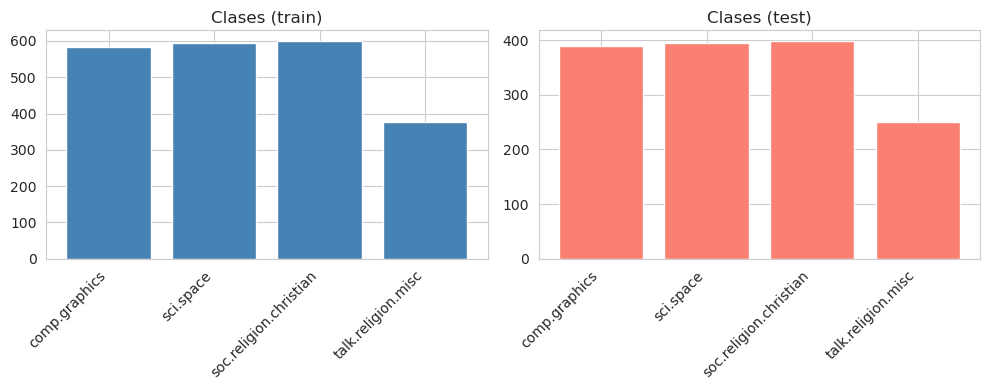

In [344]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Distribución de clases en train/test
cnt_tr = Counter(train.target)
cnt_te = Counter(test.target)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].bar(range(K), [cnt_tr[k] for k in range(K)], color='steelblue')
axs[0].set_title('Clases (train)')
axs[0].set_xticks(range(K))
axs[0].set_xticklabels(train.target_names, rotation=45, ha='right')
axs[1].bar(range(K), [cnt_te[k] for k in range(K)], color='salmon')
axs[1].set_title('Clases (test)')
axs[1].set_xticks(range(K))
axs[1].set_xticklabels(train.target_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()


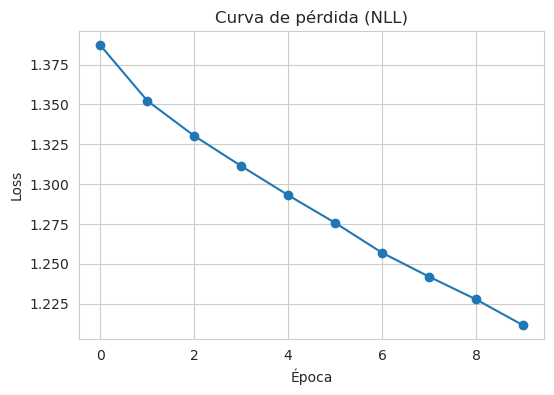

In [345]:
# Entrenamiento nuevamente para registrar historia de loss
W_hist = 0.01 * np.random.randn(V, K).astype(np.float32)
b_hist = np.zeros((K,), dtype=np.float32)

lr_h = 0.5
reg_h = 1e-4
epochs_h = 10
loss_history = []
for ep in range(1, epochs_h+1):
    loss, gW, gb = nll_and_grad(indptr_tr, indices_tr, data_tr, y_tr, W_hist, b_hist, reg=reg_h, batch_size=256)
    W_hist -= lr_h * gW
    b_hist -= lr_h * gb
    loss_history.append(loss)

plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o')
plt.title('Curva de pérdida (NLL)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


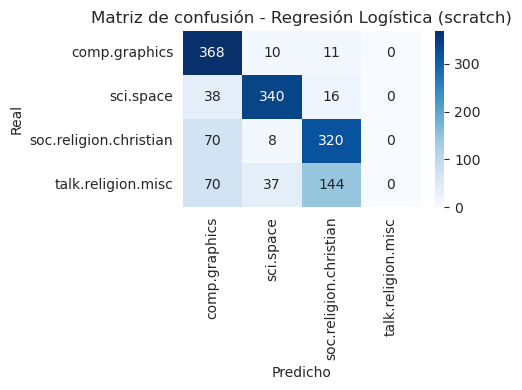

In [346]:
# Heatmap de matriz de confusión para el modelo entrenado previamente (W, b)
import numpy as np
import seaborn as sns

cm_lr = cm  # reutilizamos la cm ya calculada
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión - Regresión Logística (scratch)')
plt.tight_layout()
plt.show()


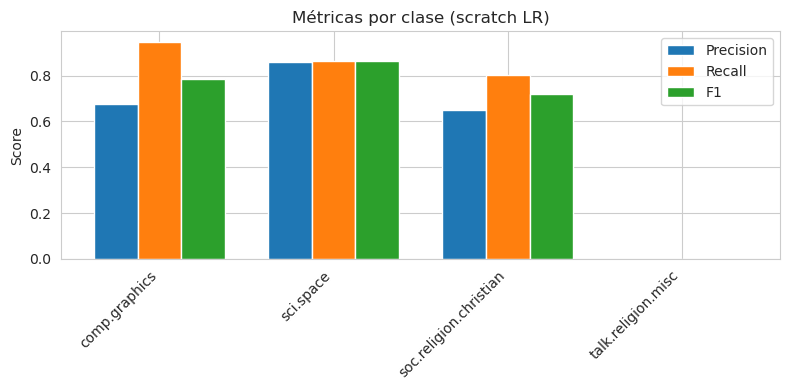

In [347]:
# Barras por clase: Precision, Recall, F1
x = np.arange(K)
width = 0.25

plt.figure(figsize=(8,4))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x,         recalls,   width, label='Recall')
plt.bar(x + width, f1s,       width, label='F1')
plt.xticks(x, train.target_names, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Métricas por clase (scratch LR)')
plt.legend()
plt.tight_layout()
plt.show()


In [348]:
# Palabras más importantes por clase según pesos de W
# Usamos el modelo W entrenado en la sección principal (no W_hist)

inv_vocab = np.array(vocab_terms)
for k in range(K):
    top_idx = np.argsort(W[:, k])[::-1][:15]
    print(f"Clase: {train.target_names[k]}")
    print(', '.join(inv_vocab[top_idx]))
    print('-'*60)


Clase: comp.graphics
graphics, file, image, polygon, windows, files, thanks, package, vga, tiff, uk, host, color, gif, computer
------------------------------------------------------------
Clase: sci.space
space, nasa, henry, alaska, access, moon, digex, orbit, gov, toronto, pat, launch, zoo, shuttle, jpl
------------------------------------------------------------
Clase: soc.religion.christian
the, god, that, of, to, we, is, he, not, as, and, church, in, jesus, are
------------------------------------------------------------
Clase: talk.religion.misc
sandvik, morality, that, kent, you, apple, objective, com, the, jesus, koresh, he, christian, buffalo, brian
------------------------------------------------------------


In [349]:
# Ejemplos mal clasificados: mostramos 3 aleatorios con snippet
mis_idx = np.where(y_te != y_pred)[0]
np.random.shuffle(mis_idx)
for i in mis_idx[:3]:
    true_c = train.target_names[y_te[i]]
    pred_c = train.target_names[y_pred[i]]
    print('='*80)
    print(f'True: {true_c} | Pred: {pred_c}')
    snippet = test.data[i][:400].replace('\n', ' ')
    print(snippet)



True: talk.religion.misc | Pred: soc.religion.christian
From: psyrobtw@ubvmsd.cc.buffalo.edu (Robert Weiss) Subject: Re: [rw] Is Robert Weiss the only orthodox Christian? Organization: University at Buffalo Lines: 86 News-Software: VAX/VMS VNEWS 1.41 Nntp-Posting-Host: ubvmsd.cc.buffalo.edu  In article <93111.074840LIBRBA@BYUVM.BITNET>, LIBRBA@BYUVM.BITNET writes...  Rick Anderson writes:  ra>   Robert, you keep making references to "orthodox" belief, 
True: talk.religion.misc | Pred: soc.religion.christian
From: mls@panix.com (Michael Siemon) Subject: commandments I (the basics) Organization: PANIX Public Access Unix, NYC Lines: 205  Why should anyone (check: let's restrict this to Christians, why do *we*) want to find "commandments" in the books regarded as scripture?  What's going on? I will pass on psychologizing answers (whether dismissive or more open) as not the kind of issue to deal with here
True: talk.religion.misc | Pred: soc.religion.christian
From: Nanci Ann Miller <nm0w+@

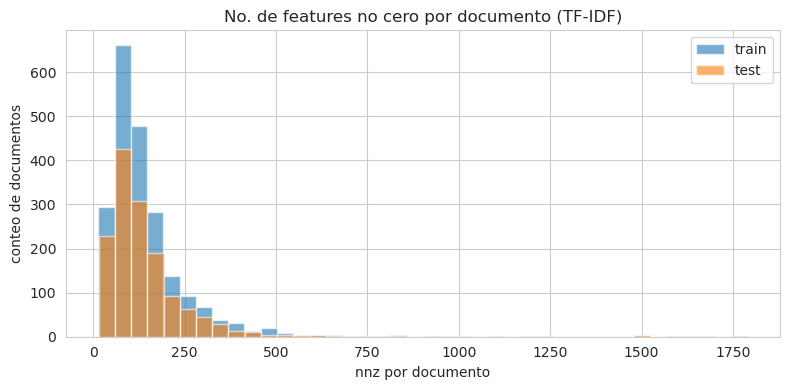

In [350]:
# Histograma de número de features no cero por documento (sparsity)

def count_nnz(indptr):
    # nnz por fila = diferencia en punteros
    return np.diff(indptr)

nnz_tr = count_nnz(indptr_tr)
nnz_te = count_nnz(indptr_te)
plt.figure(figsize=(8,4))
plt.hist(nnz_tr, bins=40, alpha=0.6, label='train')
plt.hist(nnz_te, bins=40, alpha=0.6, label='test')
plt.title('No. de features no cero por documento (TF‑IDF)')
plt.xlabel('nnz por documento')
plt.ylabel('conteo de documentos')
plt.legend()
plt.tight_layout()
plt.show()
